# Idea
Where we describe how we'll do recommendations. We assume we have scrapped a good portion of past events, clustered them and have saved the centroids. We also assume we have this week's events embeddings.

This is also meant to be a playground to try out new ideas so it might be a little messy.

In [7]:
import requests, json, pickle, urllib, time, random, os
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

In [42]:
# First load everything
centroids = np.load('../data/centroids.npy')
current_embs = np.load('../data/current_embs.npy')
with open('../data/cluster_data/kmeans_model.pkl', 'rb') as f: m = pickle.load(f)
with open('../data/cluster_data/to_embed.json', 'r') as f: to_embed = json.loads(f.read())
centroids.shape, current_embs.shape

/home/main/.local/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KMeans from version 1.4.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


((1000, 1536), (641, 1536))

In [3]:
# Then compute the euclidian distances of new embeddings to the centroids
# Could do it manually but can use sklearn's optimized function
# Note: could also use m.transform(current_embs) but we could avoid loading the model this way
dists_to_centroids = euclidean_distances(current_embs, centroids)
dists_to_centroids.shape

(641, 1000)

In [4]:
# We'll weight how much each cluster can say about each event by how far away they are
eps = 1e-5
weights = (1 / (dists_to_centroids + eps))
weights /= weights.sum(axis=1)[:, np.newaxis]
weights.shape

(641, 1000)

In [10]:
# We'll imagine that users "rate clusters". I.e. we'll maintain a (n_clusters,) vector "rating" each of the clusters
# TODO: determine how to initialize
# sd = 0.001
user_ratings = np.zeros(len(centroids))#np.random.randn(len(centroids)) * sd
# user_ratings[0] = 2
user_ratings.shape, user_ratings.mean(), user_ratings.std()

((1000,), np.float64(0.0), np.float64(0.0))

(array([169., 649., 102.,  25.,  16.,  14.,  17.,   5.,   1.,   2.]),
 array([0.00080249, 0.00091715, 0.0010318 , 0.00114645, 0.0012611 ,
        0.00137575, 0.0014904 , 0.00160505, 0.00171971, 0.00183436,
        0.00194901]),
 <BarContainer object of 10 artists>)

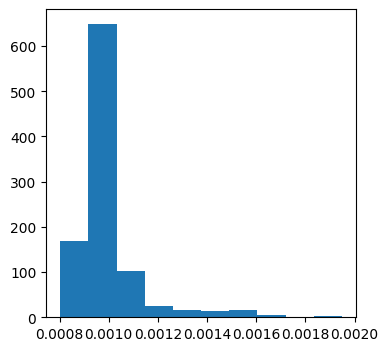

In [8]:
plt.figure(figsize=(4,4)); plt.hist(weights[-2])

In [16]:
preds = (weights @ user_ratings)
preds.shape

(641,)

(array([ 25.,  42.,  31.,  60.,  90., 116., 113., 100.,  62.,   2.]),
 array([0.00199875, 0.00199972, 0.00200068, 0.00200165, 0.00200262,
        0.00200358, 0.00200455, 0.00200551, 0.00200648, 0.00200745,
        0.00200841]),
 <BarContainer object of 10 artists>)

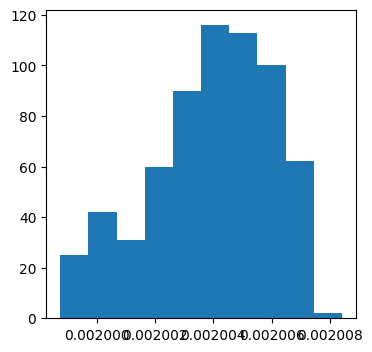

In [17]:
plt.figure(figsize=(4,4)); plt.hist(preds)

In [14]:
# (-preds).argsort()

In [15]:
# user rated the event 0 as 2:
user_ratings += 2 * weights[0]

In [35]:
import sqlite3
import matplotlib.pyplot as plt
def get_user_ratings(db: sqlite3.Connection, user_id: int) -> np.ndarray:
    query = "SELECT ratings FROM user_ratings WHERE user_id = ?"
    row = db.execute(query, (user_id,)).fetchone()
    if row is None: raise ValueError(f"No ratings found for user_id: {user_id}")
    return np.frombuffer(row[0])

db = sqlite3.connect('../data/main.db')

In [43]:
ratings = get_user_ratings(db, 11)

(array([ 21., 116., 278., 311., 155.,  77.,  24.,  12.,   4.,   2.]),
 array([-0.01599955, -0.01511732, -0.01423509, -0.01335287, -0.01247064,
        -0.01158841, -0.01070618, -0.00982396, -0.00894173, -0.0080595 ,
        -0.00717728]),
 <BarContainer object of 10 artists>)

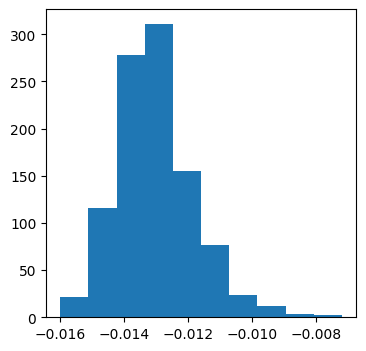

In [38]:
plt.figure(figsize=(4,4)); plt.hist(ratings)

<BarContainer object of 1000 artists>

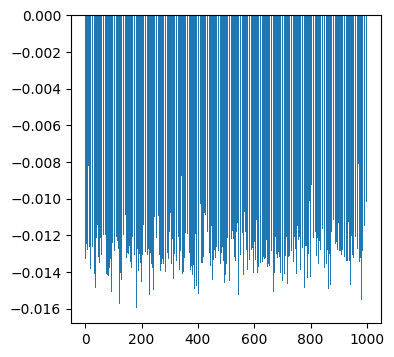

In [39]:
plt.figure(figsize=(4,4)); plt.bar(list(range(len(ratings))), ratings)

In [52]:
top_clusters = ratings.argsort()[-5:]
top_clusters

array([ 12, 970, 543, 261, 146])

In [53]:
# Inspect
for c in top_clusters:#range(n_clusters):
    print(f'Cluster {c}')
    ix = np.random.choice(np.where(m.labels_ == c)[0], 10)
    print(np.array(to_embed)[ix])
    print('\n\n')

Cluster 12
['Workshop / Seminar:Applied Interdisciplinary Mathematics (AIM) Seminar | Probing the Cores of Massive Stars through their Surface: Daniel Lecoanet (Princeton University)\nStars are opaque, which makes it difficult to study their interiors. Recent space-based telescopes have led to the new field of asteroseismology: by measuring global oscillation modes of a star, you can infer its interior properties. Massive stars have convection in their cores which can generate waves, which might be detectable at the surface. In the first part of this talk, I will describe a heuristic way of estimating wave generation by convection, and compare it to high-resolution numerical simulations in Cartesian geometry. To make quantitative predictions to compare with observations, one must run simulations in spherical geometry. In the second part of my talk, I will present a new spectral algorithm for solving nearly arbitrary, tensorial PDEs in spherical coordinates. The chall...\nWhere:Virtual\